In [45]:
#%matplotlib notebook
%matplotlib inline
import torch as th
import data_handler
import dilated_model as DM
import trainer as T
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from trainer import ema
import os
#sns.set_context('poster')
#sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 14, 7
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#sns.set_palette(sns.color_palette("Paired", n_colors=8, desat=.7))

In [4]:
from glob import glob
quart_trainers = []
for t in glob('saved/*quart*/**/trainer'):
    print('%8d'%os.path.getsize(t[:-7]+'/state_dict'), '%60s'%t, end='  MAX: ')
    quart_trainers.append(th.load(t))
    print(quart_trainers[-1].test_highscore)
quart_trainers.sort(key=lambda x: x.test_highscore)
quart_trainers.pop()

 3704896                             saved/RELU-16-quart/0001/trainer  MAX: 0.8226732015609741
 3704894                             saved/SELU-16-quart/0001/trainer  MAX: 0.8264732956886292
 3704900                        saved/ADAM-SELU-16-quart/0001/trainer  MAX: 0.8476480841636658
 3704896                        saved/ADAM-SELU-16-quart/0003/trainer  MAX: 0.8526226878166199
 3704894                        saved/ADAM-RELU-16-quart/0001/trainer  MAX: 0.8335200548171997
 3704896                        saved/ADAM-RELU-16-quart/0003/trainer  MAX: 0.8002257943153381
 2885849             saved/RESNET-quarter-K4N1-selu-adam/0001/trainer  MAX: 0.8011949062347412
  644591           saved/FREQ-SKIP-FCN-quarter-selu-adam/0001/trainer  MAX: 0.9108186960220337
  644591           saved/FREQ-SKIP-FCN-quarter-selu-adam/0002/trainer  MAX: 0.6692318916320801
 2769684             saved/FREQ-ENCODE-quarter-selu-adam/0001/trainer  MAX: 1.0480226278305054
 2769684             saved/FREQ-ENCODE-quarter-sel

In [5]:
quart_trainers.reverse()
for t in quart_trainers:
    print('%8d'%os.path.getsize(t.path+'/state_dict'), '%60s'%t.path[5:], end='  MAX: ')
    print(t.test_highscore)
    


 3712510                              /FREQ-ADAM-SELU-16-quarter/0001  MAX: 0.9467489123344421
  644591                        /FREQ-SKIP-FCN-quarter-selu-adam/0001  MAX: 0.9108186960220337
 5047178                              /FREQ-ADAM-SELU-19-quarter/0001  MAX: 0.8838381767272949
 3704896                                     /ADAM-SELU-16-quart/0003  MAX: 0.8526226878166199
 2769684                          /FREQ-ENCODE-quarter-selu-adam/0005  MAX: 0.8525879383087158
 3704900                                     /ADAM-SELU-16-quart/0001  MAX: 0.8476480841636658
 2769684                          /FREQ-ENCODE-quarter-selu-adam/0008  MAX: 0.83958500623703
 3704894                                     /ADAM-RELU-16-quart/0001  MAX: 0.8335200548171997
 3704894                                          /SELU-16-quart/0001  MAX: 0.8264732956886292
 3704896                                          /RELU-16-quart/0001  MAX: 0.8226732015609741
 2769684                          /FREQ-ENCODE-quart

<IPython.core.display.Javascript object>


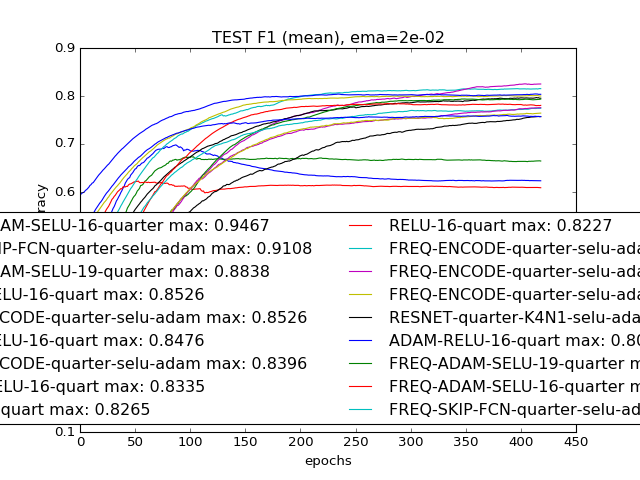

In [6]:
#%matplotlib notebook
ALPHA = 0.02
#sns.set_palette(sns.color_palette("Set1", n_colors=14, desat=.8))
def add_plot(T, alpha=ALPHA):
    plt.plot(ema(th.cat(T.test_F1)[:, -1], alpha), 
             label=T.path[6:-5]+' max: %.4f'%T.test_highscore)
    
plt.close()
plt.title('TEST F1 (mean), ema=%.0e' % ALPHA)
for t in quart_trainers:
    add_plot(t)
plt.xlabel('epochs')
plt.ylabel('Test F1 accuracy')
plt.legend(loc='lower center', ncol=2)
plt.show()

#  WINNER IS
## A : = ADAM-SELU-16-quart/0003                            **(100 min)**
## B : = FREQ-ENCODE-quarter-selu-adam/0005     **(65 min)**

In [7]:
A = quart_trainers[3]
B = quart_trainers[4]

<IPython.core.display.Javascript object>


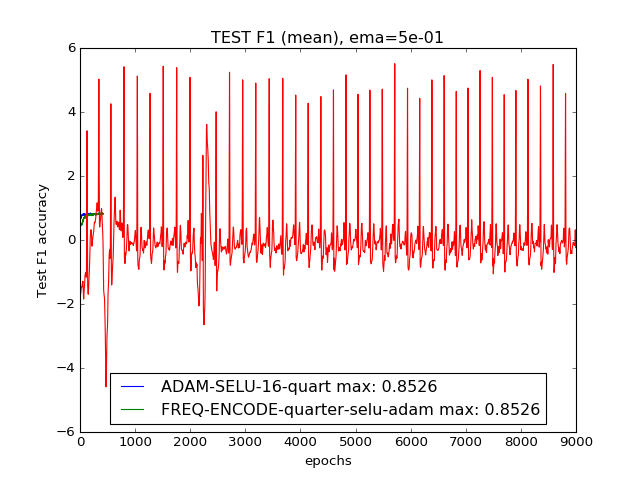

In [9]:
#%matplotlib notebook
ALPHA = 0.5
#sns.set_palette(sns.color_palette("Set1", n_colors=14, desat=.8))
def add_plot(T, alpha=ALPHA):
    plt.plot(ema(th.cat(T.test_F1)[:, -1], alpha), 
             label=T.path[6:-5]+' max: %.4f'%T.test_highscore)
    
plt.close()
plt.title('TEST F1 (mean), ema=%.0e' % ALPHA)
for t in A, B:
    add_plot(t)
plt.xlabel('epochs')
plt.ylabel('Test F1 accuracy')
plt.legend(loc='lower center', ncol=1)
plt.show()

# Restore trained models

In [12]:
th.multiprocessing.set_sharing_strategy('file_system')

transformations = [
    data_handler.Crop(8000),
    data_handler.RandomMultiplier(-1),
    data_handler.Spectogram(15),
    data_handler.Logarithm()
]
dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_composed,
    transformations=transformations,
    path='data/raw/training2017/',
    remove_noise=True, tokens='NAO')
train_set, eval_set = dataset.disjunct_split(.9)
train_producer = th.utils.data.DataLoader(
        dataset=train_set, batch_size=256, shuffle=True,
        num_workers=4, collate_fn=data_handler.batchify)
test_producer = th.utils.data.DataLoader(
        dataset=eval_set, batch_size=256, shuffle=True,
        num_workers=4, collate_fn=data_handler.batchify)

net = DM.EncodeWideResNet(in_channel=8, init_channel=8,
    num_enc_layer=4, N_res_in_block=1, use_selu=True, bias=True)

D1 = net.state_dict()
D2 = th.load('saved/FREQ-ENCODE-quarter-selu-adam/0005/state_dict_highscore')
net.load_state_dict(D2)
print(net(next(iter(train_producer))['x']).size())


trainer = T.Trainer('finetune/FREQ-ENCODE-quarter-selu-adam/0005', dryrun=True)
#trainer(net, train_producer, test_producer, gpu_id=0, useAdam=True)

EncodeWideResNet (
  (nonlin): SELU (
  )
  (encoder): Sequential (
    (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True)
    (2): SELU (
    )
    (3): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True)
    (6): SELU (
    )
    (7): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (10): SELU (
    )
    (11): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True)
    (14): SELU (
    )
    (15): MaxPool1d (size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [13]:
for u, v in zip(D1.items(), D2.items()):
    print('%30s'%str(u[0]), '%30s'%str(v[1].size()), '%30s'%str(u[0]), '%30s'%str(u[1].size()))

              encoder.0.weight          torch.Size([8, 8, 7])               encoder.0.weight          torch.Size([8, 8, 7])
                encoder.0.bias                torch.Size([8])                 encoder.0.bias                torch.Size([8])
              encoder.1.weight                torch.Size([8])               encoder.1.weight                torch.Size([8])
                encoder.1.bias                torch.Size([8])                 encoder.1.bias                torch.Size([8])
        encoder.1.running_mean                torch.Size([8])         encoder.1.running_mean                torch.Size([8])
         encoder.1.running_var                torch.Size([8])          encoder.1.running_var                torch.Size([8])
              encoder.4.weight         torch.Size([16, 8, 7])               encoder.4.weight         torch.Size([16, 8, 7])
                encoder.4.bias               torch.Size([16])                 encoder.4.bias               torch.Size([16])
        

In [14]:
inspect_dataset = data_handler.DataSet(
    'data/raw/training2017/REFERENCE.csv', data_handler.load_composed,
    path='data/raw/training2017/',
    remove_noise=False, tokens='NAO~')
data_iter = iter(inspect_dataset)
data_sample = next(data_iter)

In [15]:
len(inspect_dataset.class_lists), inspect_dataset.tokens

(4, 'NAO~')

In [50]:
N_idx = 0
A_idx = 0
O_idx = 0

def plot_normal(d=0, transformations=[], dd=None):
    global N_idx
    N_idx += d
    if dd is not None:
        N_idx = dd
    data = data_handler.load_composed(
        inspect_dataset.path + inspect_dataset.class_lists[0][N_idx], 
        transformations=transformations)
    label, sample, length = data['y'], data['x'], data['len']
    plt.figure()
    plt.title(inspect_dataset.class_lists[0][N_idx])
    plt.plot(sample.numpy().squeeze())
    
def plot_af(d=0, transformations=[], dd=None):
    global A_idx
    A_idx += d
    if dd is not None:
        A_idx = dd
    data = data_handler.load_composed(
        inspect_dataset.path + inspect_dataset.class_lists[1][N_idx], 
        transformations=transformations)
    label, sample, length = data['y'], data['x'], data['len']
    plt.figure()
    plt.title(inspect_dataset.class_lists[1][A_idx])
    plt.plot(sample.numpy().squeeze())
    
def plot_other(d=0, transformations=[], dd=None):
    global O_idx
    O_idx += d
    if dd is not None:
        O_idx = dd
    data = data_handler.load_composed(
        inspect_dataset.path + inspect_dataset.class_lists[2][N_idx], 
        transformations=transformations)
    label, sample, length = data['y'], data['x'], data['len']
    plt.figure()
    plt.title(inspect_dataset.class_lists[2][O_idx])
    plt.plot(sample.numpy().squeeze())    

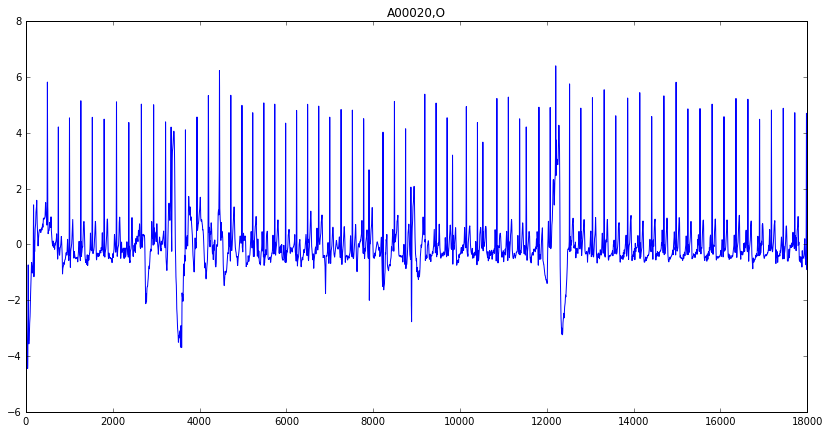

In [51]:
plot_other(dd=3)

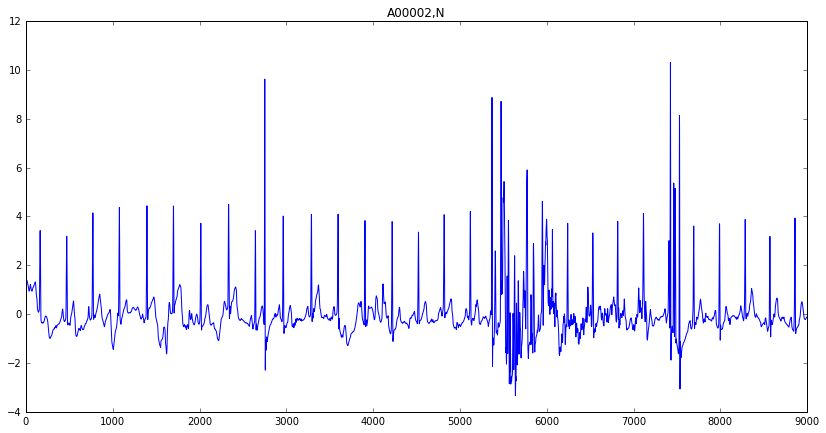

In [66]:
plot_normal(1)

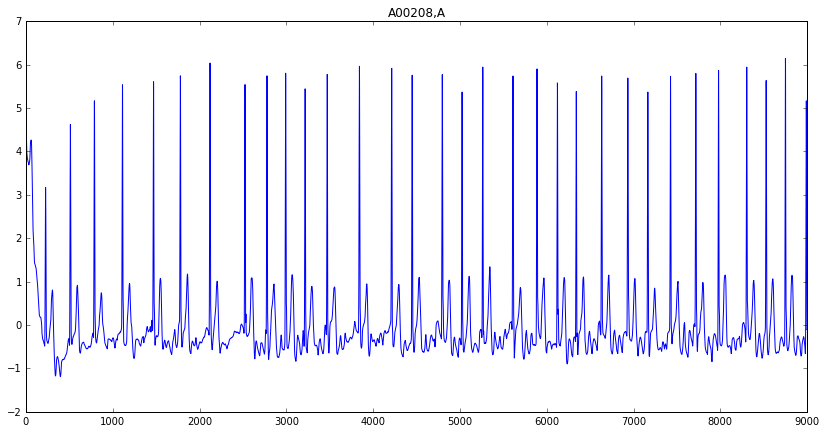

In [63]:
plot_af(2)